In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import TensorDataset
import numpy as np
import copy

In [34]:
latent_dims = 20
num_epochs = 30
batch_size = 256
capacity = 64
learning_rate = 1e-3
variational_beta = 1
noise_stdev = 0.1667

In [3]:
train_dataset = datasets.MNIST(root='./data', train = True, download = True, transform = ToTensor())
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.MNIST(root='./data', train = False, download = True, transform = ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cuda


In [35]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x

class NoisyLatentVariationalAutoencoder(nn.Module):
    def __init__(self):
        super(NoisyLatentVariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        latent = torch.add(latent, torch.randn(latent_dims, device=device) * noise_stdev)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar, sampleme=False):
        if self.training or sampleme:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')

    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + variational_beta * kldivergence


vae_init = NoisyLatentVariationalAutoencoder().to(device)

num_params = sum(p.numel() for p in vae_init.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 647081


In [36]:
def train_vae_gen(vae, train_dataloader, sample_vae=False, sample_from=None):
  vae = vae.to(device)

  num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
  print('Number of parameters: %d' % num_params)

  optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

  vae.train()

  train_loss_avg = []

  print('Training ...')
  for epoch in range(num_epochs):
      train_loss_avg.append(0)
      num_batches = 0

      for image_batch, _ in train_dataloader:

          image_batch = image_batch.to(device)

          if sample_vae:
            with torch.no_grad():
              # image_batch = image_batch.to(device)
              latent = torch.randn(image_batch.shape[0], latent_dims, device=device)
              image_batch = sample_from.decoder(latent)

          # vae reconstruction
          image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

          # reconstruction error
          loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

          # backpropagation
          optimizer.zero_grad()
          loss.backward()

          # one step of the optmizer (using the gradients from backpropagation)
          optimizer.step()

          train_loss_avg[-1] += loss.item()
          num_batches += 1

      train_loss_avg[-1] /= num_batches
      print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

In [37]:
train_vae_gen(vae_init, train_dataloader, False, None)

Number of parameters: 647081
Training ...
Epoch [1 / 30] average reconstruction error: 44096.059691
Epoch [2 / 30] average reconstruction error: 31634.503009
Epoch [3 / 30] average reconstruction error: 29903.511553
Epoch [4 / 30] average reconstruction error: 29134.574934
Epoch [5 / 30] average reconstruction error: 28646.579804
Epoch [6 / 30] average reconstruction error: 28465.694357
Epoch [7 / 30] average reconstruction error: 28269.382351
Epoch [8 / 30] average reconstruction error: 28133.362392
Epoch [9 / 30] average reconstruction error: 27999.084649
Epoch [10 / 30] average reconstruction error: 27917.762080
Epoch [11 / 30] average reconstruction error: 27779.203686
Epoch [12 / 30] average reconstruction error: 27801.889478
Epoch [13 / 30] average reconstruction error: 27772.985414
Epoch [14 / 30] average reconstruction error: 27626.487060
Epoch [15 / 30] average reconstruction error: 27561.741248
Epoch [16 / 30] average reconstruction error: 27491.724036
Epoch [17 / 30] average

Original images


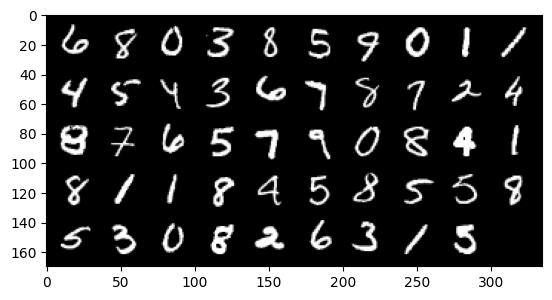

VAE reconstruction:


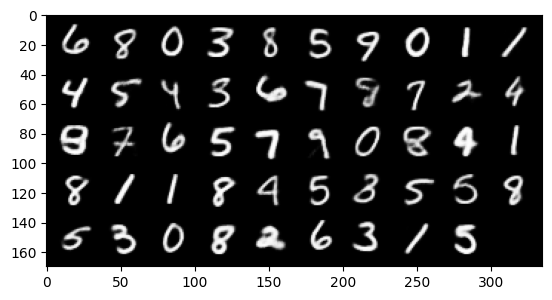

In [38]:
plt.ion()

vae_init.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

for images, labels in test_dataloader:
  break

# First visualise the original images
print('Original images')
show_image(make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae_init)

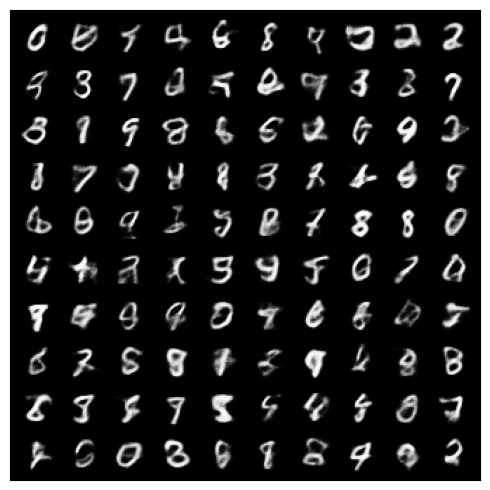

In [39]:
latent = torch.randn(128, latent_dims, device=device)

# reconstruct images from the latent vectors
img_recon = vae_init.decoder(latent)
img_recon = img_recon.cpu()

fig, ax = plt.subplots(figsize=(5, 5))
show_image(make_grid(img_recon.data[:100],10,5))
# plt.show()
plt.xticks([])
plt.yticks([])

plt.tight_layout()

In [40]:
def collapse(samples, loss):
    vae = copy.deepcopy(vae_init).to(device)
    for i in range(20):
        print(f"Generation {i+1}")
    
        latent = torch.randn(2560, latent_dims, device=device)
        
        # reconstruct images from the latent vectors
        img_recon = vae.decoder(latent).clone().detach()
        samples.append(img_recon.data[:100].cpu())
    
        x_recon, latent_mu, latent_logvar = vae(img_recon)
        loss.append(vae_loss(x_recon, img_recon, latent_mu, latent_logvar))
        
        train_recon = TensorDataset(img_recon, torch.zeros(2560, 1))
        train_dataloader = DataLoader(train_recon, batch_size=batch_size, shuffle=True)
        train_vae_gen(vae, train_dataloader, False, None)
        

In [41]:
samples = []
loss = []
collapse(samples, loss)

Generation 1
Number of parameters: 647081
Training ...
Epoch [1 / 30] average reconstruction error: 39227.875781
Epoch [2 / 30] average reconstruction error: 38441.694922
Epoch [3 / 30] average reconstruction error: 38163.235547
Epoch [4 / 30] average reconstruction error: 38023.400781
Epoch [5 / 30] average reconstruction error: 37811.954297
Epoch [6 / 30] average reconstruction error: 37754.139062
Epoch [7 / 30] average reconstruction error: 37458.540625
Epoch [8 / 30] average reconstruction error: 37577.524609
Epoch [9 / 30] average reconstruction error: 37571.004687
Epoch [10 / 30] average reconstruction error: 37582.201953
Epoch [11 / 30] average reconstruction error: 37578.366797
Epoch [12 / 30] average reconstruction error: 37311.369531
Epoch [13 / 30] average reconstruction error: 37404.666797
Epoch [14 / 30] average reconstruction error: 37349.458984
Epoch [15 / 30] average reconstruction error: 37279.469531
Epoch [16 / 30] average reconstruction error: 37359.844922
Epoch [17 

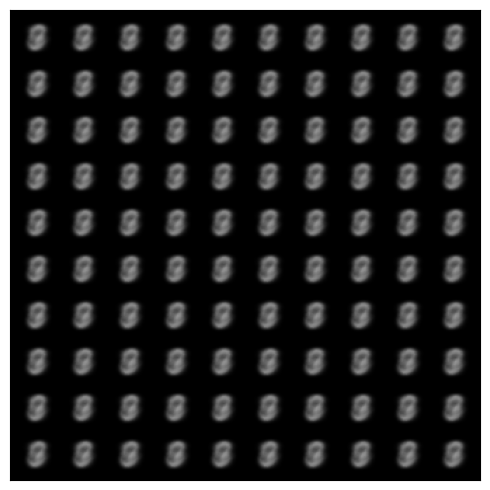

In [42]:
fig, ax = plt.subplots(figsize=(5, 5))
show_image(make_grid(samples[9],10,5))
# plt.show()
plt.xticks([])
plt.yticks([])

plt.tight_layout()
# plt.savefig('gen20_collapse.png')